# Models with LDA (4 class, (n=3)components)

## Import library and dataset

In [6]:
# Import libraries
import numpy as np
import pandas as pd
import pandas_profiling
from pandas_profiling import ProfileReport
#import tkinter
from matplotlib import pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import scikitplot as skplt
import seaborn as sns
sns.set(style="whitegrid")

#from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline
from sklearn import model_selection

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import matplotlib
matplotlib.use('TKAgg')
%matplotlib inline

## Load Dataset, Scaling

In [2]:
# Load 2 datasets
dfC = pd.read_csv("MeterC",sep='\t',header=None, names=['flatr','symm','crossf','v1','v2','v3','v4','sos1','sos2','sos3','sos4','ss11','ss12','ss21','ss22','ss31','ss32','ss41','ss42','sq11','sq12','sq21','sq22','sq31','sq32','sq41','sq42','gain11','gain12','gain21','gain22','gain31','gain32','gain41','gain42','tt11','tt12','tt21','tt22','tt31','tt32','tt41','tt42','class'])
dfD = pd.read_csv("MeterD",sep='\t',header=None, names=['flatr','symm','crossf','v1','v2','v3','v4','sos1','sos2','sos3','sos4','ss11','ss12','ss21','ss22','ss31','ss32','ss41','ss42','sq11','sq12','sq21','sq22','sq31','sq32','sq41','sq42','gain11','gain12','gain21','gain22','gain31','gain32','gain41','gain42','tt11','tt12','tt21','tt22','tt31','tt32','tt41','tt42','class'])

# Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = ['flatr','symm','crossf','v1','v2','v3','v4','sos1','sos2','sos3','sos4','ss11','ss12','ss21','ss22','ss31','ss32','ss41','ss42','sq11','sq12','sq21','sq22','sq31','sq32','sq41','sq42','gain11','gain12','gain21','gain22','gain31','gain32','gain41','gain42','tt11','tt12','tt21','tt22','tt31','tt32','tt41','tt42']

X = dfC.loc[:, features].values
y = dfC.loc[:,['class']].values
X = scaler.fit_transform(X)

#process for dataset D
Xd = dfD.loc[:, features].values
yd = dfD.loc[:,['class']].values
Xd = scaler.fit_transform(Xd)

#change the shape of y from column array to horizontal array or (n_samples, ) using ravel().
y = y.ravel()
print('y class',dfC['class'].unique())
yd = yd.ravel()
print('yd class',dfD['class'].unique())

y class [1 2 3 4]
yd class [1 2 3 4]


## Apply LDA

In [3]:
lda = LDA(n_components=3)
X = lda.fit_transform(X,y)

lda1 = LDA(n_components=3)
Xd = lda1.fit_transform(Xd,yd)

print(np.cumsum(lda.explained_variance_ratio_))
print(np.cumsum(lda1.explained_variance_ratio_))

[0.63388886 0.96162089 1.        ]
[0.99826018 0.99970148 1.        ]


## Evaluate using K-fold validation

In [7]:
#classifier models
clfNB = GaussianNB()
clfKNN = KNeighborsClassifier(n_neighbors=5)
clfSVM = svm.SVC(kernel='linear', C=1, probability=True)
clfRF = RandomForestClassifier(max_depth=2, random_state=0)
clfNN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=1, max_iter=2500)

n_folds = [5,10]
targets = [clfNB,clfKNN,clfSVM,clfRF,clfNN]
models = ['Bayes','KNN','SVM','RF','ANN']
# Computing training scores to get insights on how different parameter settings impact the overfitting/underfitting trade-off. 
# However computing the scores on the training set can be computationally expensive and is not strictly required 
# to select the parameters that yield the best generalization performance

print("\n{:>10} | {:>10} | {:>8} | {:>10} | {:>10} | {:>9},{:>9},{:>7} | {:>9},{:>9},{:>8}".format('Classifier', 'Test_Accy_5f', 'Test_Accy_10f', 'Val_Accy_5f','Val_Accy_10f','F1micro5','F1macro5','F1avg5','F1micro10','F1macro10','F1avg10'))
print('-----------------------------------------------------------------------------------------------------------------------------------')
for i,j in zip(targets,models):
    # K-fold cross validation for the training dataset (Dataset C)
    cv5 = cross_validate(i, X, y, cv=5, return_train_score=True) # == cvScore = cross_val_score(i, X, y, cv=5)
    cv10 = cross_validate(i, X, y, cv=10, return_train_score=True)    
    cv5mean = np.round(cv5['test_score'].mean(),decimals=3)
    cv10mean = np.round(cv10['test_score'].mean(),decimals=3)
    # K-fold cross validation and predict for the validation dataset (Dataset D)
    y_pred5 = cross_val_predict(i, Xd, yd, cv=5)
    y_pred10 = cross_val_predict(i, Xd, yd, cv=10)
    # Evaluate performance for validation score
    accuracy5 = np.round(accuracy_score(yd, y_pred5),decimals=3)
    accuracy10 = np.round(accuracy_score(yd, y_pred10),decimals=3)
    f1micro5 = np.round(f1_score(yd, y_pred5, average='macro'),decimals=3)
    f1macro5 = np.round(f1_score(yd, y_pred5, average='micro'),decimals=3)
    f1avg5 = np.round(f1_score(yd, y_pred5, average='weighted'),decimals=3)
    f1micro10 = np.round(f1_score(yd, y_pred10, average='macro'),decimals=3)
    f1macro10 = np.round(f1_score(yd, y_pred10, average='micro'),decimals=3)
    f1avg10 = np.round(f1_score(yd, y_pred10, average='weighted'),decimals=3)
    print("{:>10} | {:>12} | {:>13} | {:>11} | {:>11}  | {:>9}{:>9}{:>9} | {:>9}{:>9}{:>9}".format(j,cv5mean,cv10mean,accuracy5,accuracy10,f1micro5,f1macro5,f1avg5,f1micro10,f1macro10,f1avg10))



Classifier | Test_Accy_5f | Test_Accy_10f | Val_Accy_5f | Val_Accy_10f |  F1micro5, F1macro5, F1avg5 | F1micro10,F1macro10, F1avg10
-----------------------------------------------------------------------------------------------------------------------------------
     Bayes |        0.939 |         0.945 |       0.922 |       0.922  |     0.931    0.922    0.922 |     0.931    0.922    0.922
       KNN |        0.961 |         0.961 |       0.839 |       0.856  |     0.846    0.839    0.839 |      0.86    0.856    0.856
       SVM |        0.956 |         0.961 |       0.872 |       0.883  |     0.885    0.872     0.87 |     0.896    0.883    0.882
        RF |        0.901 |         0.917 |       0.844 |       0.889  |     0.854    0.844    0.841 |     0.896    0.889    0.886
       ANN |        0.956 |         0.956 |       0.861 |       0.883  |      0.87    0.861    0.859 |     0.896    0.883    0.882


## Evaluate using Train and Test set

In [7]:
#split dataset into train and test set
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, y, test_size=0.20, random_state=100)

In [8]:
print("\n{:>10} | {:>10} | {:>10} | {:>9},{:>9},{:>7} | {:>9},{:>9},{:>8}".format('Classifier', 'AccuracyC','AccuracyD','F1microC','F1macroC','F1avgC','F1microD','F1macroD','F1avgD'))
print('-------------------------------------------------------------------------------------------------')
for i,j in zip(targets,models):
    i.fit(X_train, Y_train) # train the model
    accuracyC = np.round(i.score(X_test, Y_test),decimals=3) # Calc accuracy score for the training dataset (Dataset C)
    accuracyD = np.round(i.score(Xd, yd),decimals=3) # Calc accuracy score for the validation dataset (Dataset D)
    # Evaluate performance for validation score
    y_predC = i.predict(X_test)
    y_predD = i.predict(Xd)
    f1microC = np.round(f1_score(Y_test, y_predC, average='macro'),decimals=3)
    f1macroC = np.round(f1_score(Y_test, y_predC, average='micro'),decimals=3)
    f1avgC = np.round(f1_score(Y_test, y_predC, average='weighted'),decimals=3)
    f1microD = np.round(f1_score(yd, y_predD, average='macro'),decimals=3)
    f1macroD = np.round(f1_score(yd, y_predD, average='micro'),decimals=3)
    f1avgD = np.round(f1_score(yd, y_predD, average='weighted'),decimals=3)
    print("{:>10} | {:>10} | {:>10} | {:>9}{:>9}{:>9} | {:>9}{:>9}{:>9}".format(j,accuracyC,accuracyD,f1microC,f1macroC,f1avgC,f1microD,f1macroD,f1avgD))



Classifier |  AccuracyC |  AccuracyD |  F1microC, F1macroC, F1avgC |  F1microD, F1macroD,  F1avgD
-------------------------------------------------------------------------------------------------
     Bayes |      0.973 |      0.128 |     0.976    0.973    0.973 |     0.057    0.128    0.029
       KNN |      0.973 |        0.0 |     0.976    0.973    0.973 |       0.0      0.0      0.0
       SVM |        1.0 |        0.0 |       1.0      1.0      1.0 |       0.0      0.0      0.0
        RF |        1.0 |      0.044 |       1.0      1.0      1.0 |     0.043    0.044    0.048
       ANN |        1.0 |        0.0 |       1.0      1.0      1.0 |       0.0      0.0      0.0


## Classification Report

In [9]:
for i,j in zip(targets,models):
    i.fit(X_train, Y_train)
    y_pred = i.predict(X_test)
    print(j,'Classification Report for Test Set:\n', classification_report(Y_test, y_pred))
print('-------------------------------------------------------------------------------------------------')
for i,j in zip(targets,models):
    i.fit(X_train, Y_train)
    y_pred = i.predict(Xd)
    print(j,'Classification Report for Validation Set:\n', classification_report(yd, y_pred))


Bayes Classification Report for Test Set:
               precision    recall  f1-score   support

           1       0.89      1.00      0.94         8
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00        11
           4       1.00      0.93      0.96        14

    accuracy                           0.97        37
   macro avg       0.97      0.98      0.98        37
weighted avg       0.98      0.97      0.97        37

KNN Classification Report for Test Set:
               precision    recall  f1-score   support

           1       0.89      1.00      0.94         8
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00        11
           4       1.00      0.93      0.96        14

    accuracy                           0.97        37
   macro avg       0.97      0.98      0.98        37
weighted avg       0.98      0.97      0.97        37

SVM Classification Report for Test Set:
      

C:\Users\SMFIRDAUS\miniconda3\envs\ds\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\SMFIRDAUS\miniconda3\envs\ds\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\SMFIRDAUS\miniconda3\envs\ds\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



RF Classification Report for Validation Set:
               precision    recall  f1-score   support

           1       0.18      0.14      0.16        51
           2       0.00      0.00      0.00        23
           3       0.00      0.00      0.00        55
           4       0.01      0.02      0.01        51

    accuracy                           0.04       180
   macro avg       0.05      0.04      0.04       180
weighted avg       0.05      0.04      0.05       180

ANN Classification Report for Validation Set:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00      51.0
           2       0.00      0.00      0.00      23.0
           3       0.00      0.00      0.00      55.0
           4       0.00      0.00      0.00      51.0

    accuracy                           0.00     180.0
   macro avg       0.00      0.00      0.00     180.0
weighted avg       0.00      0.00      0.00     180.0



C:\Users\SMFIRDAUS\miniconda3\envs\ds\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## Confusion Matrix

In [5]:
for i,j in zip(targets,models):
    # K-fold cross validation for the training dataset (Dataset C)
    y_predC5 = cross_val_predict(i, X, y, cv=5)
   # print(j,'Confusion Matrix for Test Set (5-fold):\n',confusion_matrix(y, y_predC5))
    print('\n',j,'Confusion Matrix for Test Set (5-fold):\n',confusion_matrix(y, y_predC5))
    
print('--------------------------------------------------------')
      
for i,j in zip(targets,models):
    # K-fold cross validation and predict for the validation dataset (Dataset D)
    y_predD5 = cross_val_predict(i, Xd, yd, cv=5)
   # print(j,'Confusion Matrix for Test Set (5-fold):\n',confusion_matrix(y, y_predC5))
    print('\n',j,'Confusion Matrix for Validation Set (5-fold):\n',confusion_matrix(yd, y_predD5))


 Bayes Confusion Matrix for Test Set (5-fold):
 [[53  0  1  0]
 [ 0 21  2  0]
 [ 6  0 48  0]
 [ 2  0  0 48]]

 KNN Confusion Matrix for Test Set (5-fold):
 [[53  0  1  0]
 [ 0 21  2  0]
 [ 2  0 52  0]
 [ 2  0  0 48]]

 SVM Confusion Matrix for Test Set (5-fold):
 [[53  0  1  0]
 [ 0 22  1  0]
 [ 3  1 50  0]
 [ 2  0  0 48]]

 RF Confusion Matrix for Test Set (5-fold):
 [[47  0  7  0]
 [ 3 19  1  0]
 [ 6  0 48  0]
 [ 1  0  0 49]]

 ANN Confusion Matrix for Test Set (5-fold):
 [[50  1  2  1]
 [ 0 22  1  0]
 [ 3  0 51  0]
 [ 0  0  0 50]]
--------------------------------------------------------

 Bayes Confusion Matrix for Validation Set (5-fold):
 [[43  0  8  0]
 [ 1 22  0  0]
 [ 5  0 50  0]
 [ 0  0  0 51]]

 KNN Confusion Matrix for Validation Set (5-fold):
 [[35  0 16  0]
 [ 4 18  1  0]
 [ 8  0 47  0]
 [ 0  0  0 51]]

 SVM Confusion Matrix for Validation Set (5-fold):
 [[33  0 18  0]
 [ 1 22  0  0]
 [ 4  0 51  0]
 [ 0  0  0 51]]

 RF Confusion Matrix for Validation Set (5-fold):
 [[32  

## ROC and AUC Multiclass (SVM)

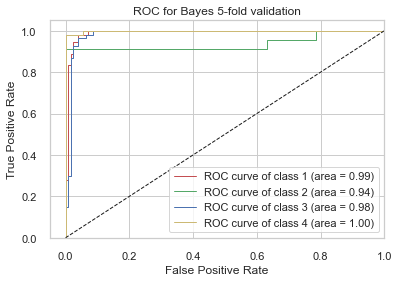

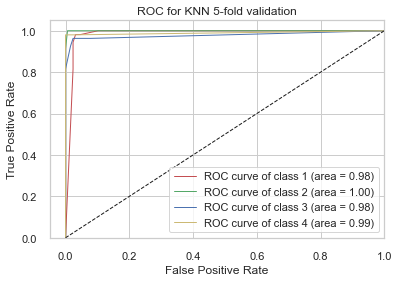

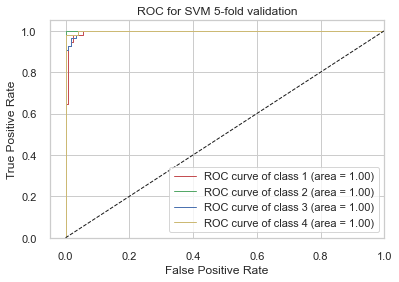

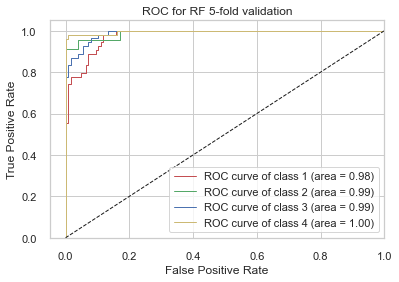

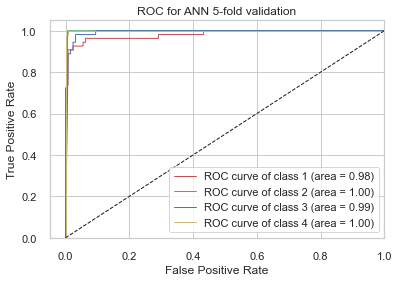

In [10]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

y_bin = label_binarize(y, classes=[1,2,3,4])
n_classes = y_bin.shape[1]
targets = [clfNB,clfKNN,clfSVM, clfRF,clfNN]
models = ['Bayes','KNN','SVM','RF','ANN']

for i,j in zip(targets,models):
    y_score = cross_val_predict(i, X, y, cv=5 ,method='predict_proba')
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    colors = cycle(['r', 'g', 'b','y'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=1,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i+1, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for ' + str(j) + ' 5-fold validation')
    plt.legend(loc="lower right")
    plt.show()


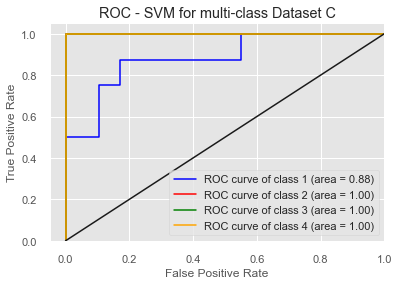

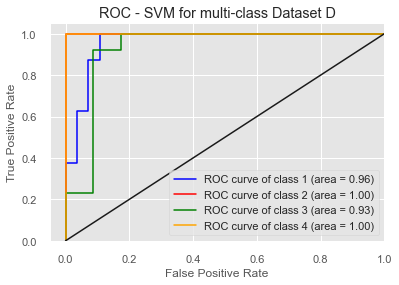

In [30]:
y_binC = label_binarize(y, classes=[1, 2, 3, 4])
y_binD = label_binarize(yd, classes=[1, 2, 3, 4])
y_bin = [y_binC, y_binD]
X_sel = [X, Xd]
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', C=1))
for i,j,k in zip(y_bin, X_sel,['Dataset C', 'Dataset D']):
    n_classes = i.shape[1]
    X_train, X_test, Y_train, Y_test = train_test_split(j, i, test_size= 0.2, random_state=100)
    y_score = classifier.fit(X_train, Y_train).decision_function(X_test)
    # Plotting and estimation of FPR, TPR
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    colors = cycle(['blue', 'red', 'green','orange'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=1.5, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i+1, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k-', lw=1.5)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC - SVM for multi-class ' + str(k))
    plt.legend(loc="lower right")
    plt.show()